#Description

In this case, the descriptions from the WRDS dataset is used for unsupervised learning, more specifically clustering. To embed the descriptions, we utilize a sentence transformer, specifically the 'all-mpnet-base-v2' model. We perform agglomerative clustering with 11 clusters, corresponding to the number of sectors under analysis. We then use TF-IDF to identify the most frequent words in each cluster. In addition, we utilized t-SNE for visualizing every sector and made a scoring function to see which cluster to which sector belongs.

#Preprocessing the dataset

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np

In [14]:
data = pd.read_csv("/content/drive/MyDrive/companyclassification/datasets/wrds_data.csv")
data.head()

,Unnamed: 0,conm,gind,gsector,naics,busdesc,spcindcd,GICS_Sector,naics_main,NAICS_Sector
0,2,AAI CORP,NaN,NaN,NaN,"AAI Corporation, together with its subsidiarie...",230.0,NaN,No,NaN
1,3,A.A. IMPORTING CO INC,255040.0,25.0,442110.0,"A.A. Importing Company, Inc. designs, manufact...",449.0,Consumer Discretionary,44,Retail Trade
2,4,AAR CORP,201010.0,20.0,423860.0,AAR Corp. provides products and services to co...,110.0,Industrials,42,Wholesale Trade
3,5,A.B.A. INDUSTRIES INC,NaN,NaN,NaN,A.B.A. Industries Inc. was acquired by McSwain...,110.0,NaN,No,NaN
4,6,ABC INDS INC,NaN,NaN,NaN,"ABC Industries, Inc. manufactures and supplies...",415.0,NaN,No,NaN


In [15]:
data = data[data.columns[2:]]

In [16]:
data.dropna(subset=['gind'], how='any', inplace=True)

In [17]:
data.drop(columns = ["spcindcd", "naics_main", "NAICS_Sector", "GICS_Sector", "naics", "gsector"], axis=1, inplace=True)

In [18]:
data['gind'] = data['gind'].astype(int)

In [19]:
data.head()

,gind,busdesc
1,255040,"A.A. Importing Company, Inc. designs, manufact..."
2,201010,AAR Corp. provides products and services to co...
5,254010,"ABKCO Music & Records, Inc. operates as an ent..."
6,151040,"Makes cold and warm forgings, including transm..."
7,203040,ACF Industries LLC operates as a machinery (co...


In [20]:
pip install -U sentence-transformers

#Embedding the sentences

In [21]:
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import os
import re
from sentence_transformers import SentenceTransformer

In [22]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(data["busdesc"].values, show_progress_bar=True)
embeddings

Batches:   0%|          | 0/1074 [00:00<?, ?it/s]

array([[ 0.029957  ,  0.04141359, -0.02761829, ..., -0.0055381 ,
        -0.00743995, -0.00918876],
       [ 0.01597208,  0.03688397, -0.01630305, ...,  0.00909176,
        -0.05975738, -0.03679692],
       [ 0.0552802 ,  0.02510208, -0.02375309, ..., -0.01607402,
        -0.0317727 , -0.01733194],
       ...,
       [-0.00189944, -0.01978962, -0.00613569, ..., -0.02044585,
         0.00122364, -0.02905013],
       [ 0.06248654,  0.00413881, -0.02005205, ..., -0.0135228 ,
         0.00901142,  0.0379914 ],
       [ 0.05214572,  0.084976  , -0.01645858, ..., -0.02006244,
        -0.01592769, -0.04295093]], dtype=float32)

#Agglomerative Clustering

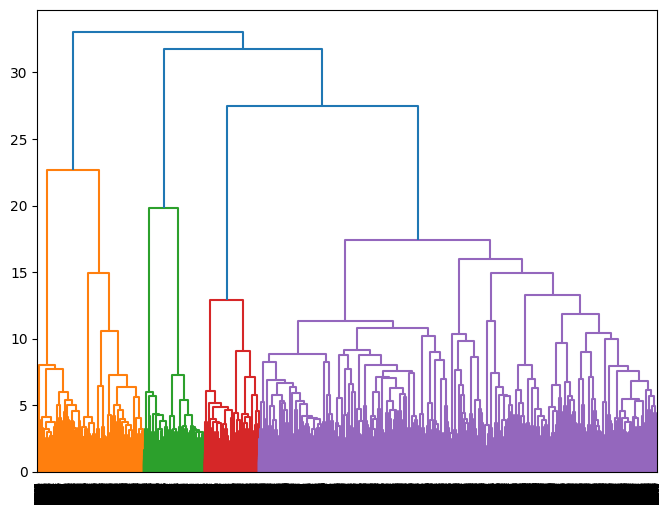

In [23]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

clusters = hierarchy.linkage(embeddings, method="ward")

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

In [24]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA

new = embeddings

connectivity = kneighbors_graph(new, n_neighbors=10, include_self=False)

model = AgglomerativeClustering(n_clusters=11, connectivity=connectivity, linkage='ward').fit(new)

In [25]:
model.labels_

array([2, 9, 9, ..., 2, 2, 9])

In [26]:
label = model.fit_predict(new)

#Most frequent words in each cluster

In [41]:
label0 = []
label1 = []
label2 = []
label3 = []
label4 = []
label5 = []
label6 = []
label7 = []
label8 = []
label9 = []
label10 = []

In [57]:
descs = data["busdesc"].values.tolist()

In [58]:
for i in range(len(label)):
  if label[i] == 0:
    label0.append(descs[i])
  if label[i] == 1:
    label1.append(descs[i])
  if label[i] == 2:
    label2.append(descs[i])
  if label[i] == 3:
    label3.append(descs[i])
  if label[i] == 4:
    label4.append(descs[i])
  if label[i] == 5:
    label5.append(descs[i])
  if label[i] == 6:
    label6.append(descs[i])
  if label[i] == 7:
    label7.append(descs[i])
  if label[i] == 8:
    label8.append(descs[i])
  if label[i] == 9:
    label9.append(descs[i])
  if label[i] == 10:
    label10.append(descs[i])

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

In [60]:
def finding_top_features(key, dataset):
  my_stop_words = list(text.ENGLISH_STOP_WORDS.union(["company"]))
  vectorizer = TfidfVectorizer(stop_words=my_stop_words)
  tfidf_matrix = vectorizer.fit_transform(dataset)
  feature_names = vectorizer.get_feature_names_out()
  feature_scores = tfidf_matrix.mean(axis=0).tolist()[0]
  features_dict = dict(zip(feature_names, feature_scores))
  sorted_features = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)
  top_features = [(feature, score) for feature, score in sorted_features[:10]]

  dictionary = {}
  dictionary[key] = top_features
  print(dictionary)

In [61]:
new_labels = {"label0" : label0,
              "label1" : label1,
              "label2" : label2,
              "label3" : label3,
              "label4" : label4,
              "label5" : label5,
              "label6" : label6,
              "label7" : label7,
              "label8" : label8,
              "label9" : label9,
              "label10" : label10}

In [62]:
for key in new_labels.keys():
  finding_top_features(key, new_labels[key])

{'label0': [('gas', 0.059518618195525896), ('oil', 0.05013656572367181), ('energy', 0.045856510744125153), ('natural', 0.04278012757061115), ('exploration', 0.034720739648712196), ('engages', 0.032148786567587836), ('development', 0.030457323501861668), ('operates', 0.030001991318491655), ('united', 0.029618062099925905), ('states', 0.029202752512225753)]}
{'label1': [('operates', 0.03882668796810929), ('products', 0.03623658332634697), ('united', 0.02932672176310657), ('states', 0.02920852776335955), ('cannabis', 0.026091627779542884), ('food', 0.023885231082258634), ('restaurants', 0.022795325737140867), ('subsidiaries', 0.02165529394149064), ('canada', 0.019249864707653927), ('engages', 0.018663007414839065)]}
{'label2': [('services', 0.030466986859056865), ('operates', 0.027738279874005102), ('products', 0.0261431127167801), ('united', 0.024529753561853277), ('provides', 0.02445208261927778), ('states', 0.0230990324578224), ('subsidiaries', 0.019154110851439924), ('corporation', 0.

#Visualization with T-SNE

In [63]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

label0_embeddings = model.encode(new_labels["label0"])
label1_embeddings = model.encode(new_labels["label1"])
label2_embeddings = model.encode(new_labels["label2"])
label3_embeddings = model.encode(new_labels["label3"])
label4_embeddings = model.encode(new_labels["label4"])
label5_embeddings = model.encode(new_labels["label5"])
label6_embeddings = model.encode(new_labels["label6"])
label7_embeddings = model.encode(new_labels["label7"])
label8_embeddings = model.encode(new_labels["label8"])
label9_embeddings = model.encode(new_labels["label9"])
label10_embeddings = model.encode(new_labels["label10"])

In [64]:
list_of_embeddings = [
    label0_embeddings,
    label1_embeddings,
    label2_embeddings,
    label3_embeddings,
    label4_embeddings,
    label5_embeddings,
    label6_embeddings,
    label7_embeddings,
    label8_embeddings,
    label9_embeddings,
    label10_embeddings
]

In [65]:
combined_embeddings = np.concatenate(list_of_embeddings, axis=0)

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', n_iter=3000)

tsne_results = tsne.fit_transform(combined_embeddings)

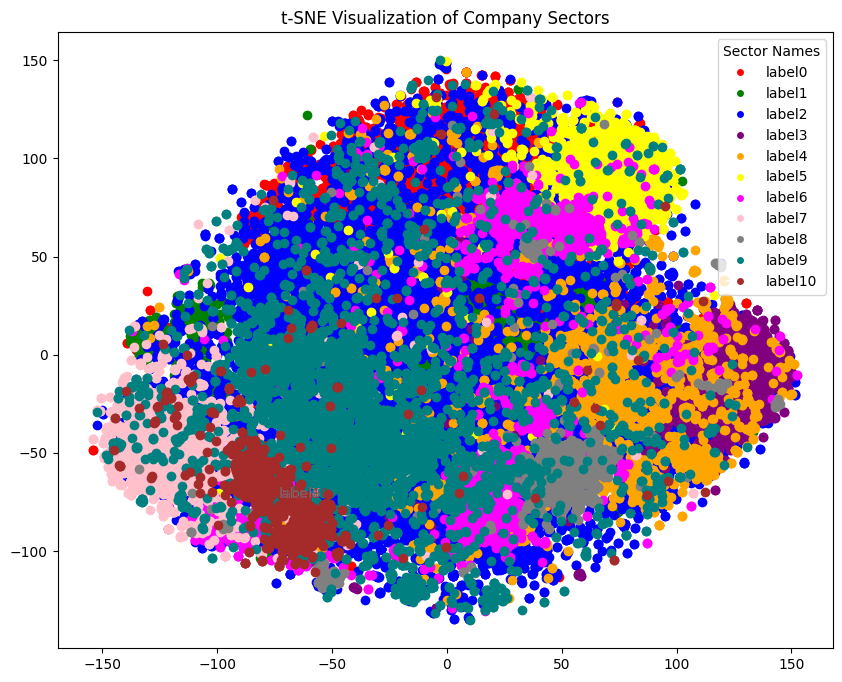

In [67]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'magenta', 'pink', 'gray', 'teal', 'brown']  # Custom colors for dots

start_index = 0
annotations = []

for i, embeddings in enumerate(list_of_embeddings):
    num_embeddings = embeddings.shape[0]
    plt.scatter(
        tsne_results[start_index : start_index + num_embeddings, 0],
        tsne_results[start_index : start_index + num_embeddings, 1],
        color=colors[i],
    )
    annotations.append(list(new_labels.keys())[i])
    start_index += num_embeddings

for i, name in enumerate(list(new_labels.keys())):
    annotation_x = np.median(tsne_results[start_index - num_embeddings : start_index, 0])
    annotation_y = np.median(tsne_results[start_index - num_embeddings : start_index, 1])
    plt.annotate(
        name,
        (annotation_x, annotation_y),
        color=colors[i],
        fontsize=10,
        alpha=0.7,
    )

plt.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], label=name) for i, name in enumerate(annotations)],
    loc='upper right',
    title='Sector Names',
)

plt.title("t-SNE Visualization of Company Sectors")
plt.show()


In [68]:
for key in new_labels.keys():
  finding_top_features(key, new_labels[key])

{'label0': [('gas', 0.059518618195525896), ('oil', 0.05013656572367181), ('energy', 0.045856510744125153), ('natural', 0.04278012757061115), ('exploration', 0.034720739648712196), ('engages', 0.032148786567587836), ('development', 0.030457323501861668), ('operates', 0.030001991318491655), ('united', 0.029618062099925905), ('states', 0.029202752512225753)]}
{'label1': [('operates', 0.03882668796810929), ('products', 0.03623658332634697), ('united', 0.02932672176310657), ('states', 0.02920852776335955), ('cannabis', 0.026091627779542884), ('food', 0.023885231082258634), ('restaurants', 0.022795325737140867), ('subsidiaries', 0.02165529394149064), ('canada', 0.019249864707653927), ('engages', 0.018663007414839065)]}
{'label2': [('services', 0.030466986859056865), ('operates', 0.027738279874005102), ('products', 0.0261431127167801), ('united', 0.024529753561853277), ('provides', 0.02445208261927778), ('states', 0.0230990324578224), ('subsidiaries', 0.019154110851439924), ('corporation', 0.

# Comparison of possible missmatched sectors

In [69]:
import math

energy = []
materials = []
industrials = []
consumer_discretionaty = []
consumer_staples = []
health_care = []
financials = []
information_technology = []
communication_services = []
utilities = []
real_estate = []

gics = list(data["gind"])
desc = list(data["busdesc"])

for i in range(len(gics)):
  if math.floor(gics[i] / 10000) == 10:
    energy.append(desc[i])
  if math.floor(gics[i] / 10000) == 15:
    materials.append(desc[i])
  if math.floor(gics[i] / 10000) == 20:
    industrials.append(desc[i])
  if math.floor(gics[i] / 10000) == 25:
    consumer_discretionaty.append(desc[i])
  if math.floor(gics[i] / 10000) == 30:
    consumer_staples.append(desc[i])
  if math.floor(gics[i] / 10000) == 35:
    health_care.append(desc[i])
  if math.floor(gics[i] / 10000) == 40:
    financials.append(desc[i])
  if math.floor(gics[i] / 10000) == 45:
    information_technology.append(desc[i])
  if math.floor(gics[i] / 10000) == 50:
    communication_services.append(desc[i])
  if math.floor(gics[i] / 10000) == 55:
    utilities.append(desc[i])
  if math.floor(gics[i] / 10000) == 60:
    real_estate.append(desc[i])

In [74]:
list_of_sectors = {
    "energy": energy,
    "materials": materials,
    "industrials": industrials,
    "consumer_discretionaty": consumer_discretionaty,
    "consumer_staples": consumer_staples,
    "health_care": health_care,
    "financials": financials,
    "information_technology": information_technology,
    "communication_services": communication_services,
    "utilities": utilities,
    "real_estate": real_estate
}

In [96]:
def finding_possible_sector_for_cluster(key, label):
  scores_per_sector = []

  for sector in list_of_sectors.keys():
    score = 0

    for item in label:
      if item in list_of_sectors[sector]:
        score += 1

    scores_per_sector.append({"sector": sector, "score": score})
    new_dict = sorted(scores_per_sector, key=lambda x: x["score"], reverse=True)

  print(f"For {key}, here are the sectors: {new_dict}")

In [97]:
for key in new_labels.keys():
  finding_possible_sector_for_cluster(key, new_labels[key])

For label0, here are the sectors: [{'sector': 'energy', 'score': 1378}, {'sector': 'utilities', 'score': 442}, {'sector': 'industrials', 'score': 398}, {'sector': 'materials', 'score': 208}, {'sector': 'consumer_discretionaty', 'score': 126}, {'sector': 'information_technology', 'score': 116}, {'sector': 'financials', 'score': 63}, {'sector': 'health_care', 'score': 49}, {'sector': 'consumer_staples', 'score': 44}, {'sector': 'real_estate', 'score': 18}, {'sector': 'communication_services', 'score': 10}]
For label1, here are the sectors: [{'sector': 'consumer_staples', 'score': 654}, {'sector': 'consumer_discretionaty', 'score': 565}, {'sector': 'health_care', 'score': 228}, {'sector': 'industrials', 'score': 73}, {'sector': 'materials', 'score': 71}, {'sector': 'financials', 'score': 63}, {'sector': 'information_technology', 'score': 36}, {'sector': 'real_estate', 'score': 33}, {'sector': 'communication_services', 'score': 15}, {'sector': 'energy', 'score': 14}, {'sector': 'utilities'